In [ ]:
# Basic imports
import numpy as np
import pandas as pd

from dataframe.csv_utils import (
    load_data_from_csv,
    get_filtered_data,
)
from constants import SORTED_BLOCK_NAMES, AUDIO_BLOCKS, COLOR_MAP, V_COLOR_MAP

# sklearn imports
from sklearn.decomposition import PCA  # Principal Component Analysis

# plotly imports
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode


FOUR_CONDITIONS = ["audio"] * 4 + ["breath"] * 4 + ["meditation", "wandering"]
VALENCE_CONDITIONS = (
    ["h_valence"] * 2
    + ["n_valence"] * 2
    + ["h_valence"] * 2
    + ["n_valence"] * 2
    + ["meditation", "wandering"]
)

AROUSAL_CONDITIONS = ["h_arousal", "l_arousal"] * 4 + ["meditation", "wandering"]

### Load features from CSV

In [ ]:
dir_name = "eeg_features2"
result = load_data_from_csv(dir_name)

In [ ]:
# This is needed so we can display plotly plots properly
init_notebook_mode(connected=True)


### Helper functions

In [156]:
from umap import UMAP

import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots

from sklearn.metrics.cluster import rand_score
from collections import defaultdict

def get_filter_pattern(feature: str = "ALL", channel: str = "") -> str:
    prefix = ""
    if len(channel) > 0:
        prefix = f"^{channel}"

    # get_other feature_pattern = ".*(?<!GAMMA|BETA2|BETA1|ALPHA|THETA|DELTA)$"
    if feature == "ALL":
        return f"{prefix}.*(?<!sdf)$"

    return f"{prefix}.*{feature}$"  # f"^{feature}.*(?<!BETA2)$"


def get_processed_feature(
    feature: str, channel: str, result: pd.DataFrame, subjects: list = []
):
    pattern = get_filter_pattern(feature, channel)
    normalized_eeg_features, filtered_result, label_list = get_filtered_data(
        result, subjects, pattern
    )
    #print("filtered", normalized_eeg_features.shape)
    return normalized_eeg_features, filtered_result


def get_umap(
    feature: str,
    channel: str,
    result: pd.DataFrame,
    all_blocks: list,
    subjects: list = [],
):
    pattern = get_filter_pattern(feature, channel)
    normalized_eeg_features, filtered_result, label_list = get_filtered_data(
        result, subjects, pattern
    )
    print(normalized_eeg_features.shape)

    # Run UMAP
    umap2d = UMAP(n_components=2, init="random", random_state=0)
    proj_2d = pd.DataFrame(umap2d.fit_transform(normalized_eeg_features))

    # Concatanate the umap points and original data
    filtered_result = filtered_result.reset_index()
    filtered_result["condition"] = all_blocks * len(subjects)
    proj_2d.columns = ["C1_2d", "C2_2d"]
    return pd.concat([filtered_result, proj_2d], axis=1, join="inner")


def get_pca(feature: str, channel: str, result: pd.DataFrame, subjects: list = []):
    normalized_eeg_features, filtered_result = get_processed_feature(
        feature, channel, result, subjects
    )

    # Run PCA
    pca = PCA(n_components=2)
    proj_2d = pd.DataFrame(pca.fit_transform(normalized_eeg_features))

    # Concatanate the umap points and original data
    filtered_result = filtered_result.reset_index()
    proj_2d.columns = ["C1_2d", "C2_2d"]
    return pd.concat([filtered_result["Subject"], proj_2d], axis=1, join="inner")


def upsample_by_attention(features, attention, num_output):
    from sklearn.preprocessing import MinMaxScaler
    import random

    scaler = MinMaxScaler(feature_range=(0, 100))
    weights = scaler.fit_transform(attention.to_numpy().reshape(-1, 1))
    
    random.seed(33)
    resampled_features = random.choices(np.arange(0, len(features), 1), weights=weights, k=num_output)

    return np.array(resampled_features)    


def show_result(
    feature: str,
    subjects: list,
    plotX: pd.DataFrame,
    conditions: list,
    to_save: bool = False,
):
    title = f"EEG {feature} (average spectral power per trial)"

    figures = []
    for subj in subjects:
        df = plotX[plotX["Subject"] == subj]
        figures.append(
            px.scatter(
                df,
                x="C1_2d",
                y="C2_2d",
                color=df["condition"],
                color_discrete_map=V_COLOR_MAP,
                opacity=0.6,
            )
        )

    fig = make_subplots(
        rows=int((len(figures) / 2) + (len(figures) % 2)),
        cols=2,
        subplot_titles=subjects,
        horizontal_spacing=0.1,
        vertical_spacing=0.05,
    )

    for i, figure in enumerate(figures):
        for trace in range(len(figure["data"])):
            figure["data"][trace].update()
            fig.append_trace(
                figure["data"][trace], row=int(i / 2 + 1), col=int(i % 2 + 1)
            )

    # Deduplicate the legends
    names = set()
    fig.for_each_trace(
        lambda trace: trace.update(showlegend=False)
        if (trace.name in names)
        else names.add(trace.name)
    )

    fig.update_layout(
        height=1000, width=1000, title_text=title, margin=dict(r=0, b=0, l=0)
    )

    name = ",".join(str(s) for s in subjects)
    filename = f"results/{feature}_{name}.png"
    if to_save:
        fig.write_image(filename)

    fig.show()


def show_pca_matrix(
    band: str,
    channel: str,
    subject: int,
    result: pd.DataFrame,
    all_blocks: list,
    n_components: int,
    to_save: bool = False,
    is_user_rating: bool = False,
):
    normalized_eeg_features, filtered_result = get_processed_feature(band, channel, result, [subject])
    sampled_list = upsample_by_attention(normalized_eeg_features, filtered_result['Attention'], 104)
    
    normalized_eeg_features = np.array(normalized_eeg_features)[sampled_list]
    all_blocks = all_blocks[sampled_list]
    
    pca = PCA(n_components=n_components)
    proj_2d = pd.DataFrame(pca.fit_transform(normalized_eeg_features))
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }

    identifier = str(subject) + f"_{band}_{channel}_channel"
    total_var = pca.explained_variance_ratio_.sum() * 100
    fig = px.scatter_matrix(
        proj_2d,
        labels=labels,
        dimensions=range(len(labels)),
        color=all_blocks,
        color_discrete_map=V_COLOR_MAP if is_user_rating else COLOR_MAP,
        opacity=0.6,
        title=f"{identifier} Total Explained Variance: {total_var:.2f}%",
    )
    fig.update_traces(diagonal_visible=False)

    # Deduplicate the legends
    names = set()
    fig.for_each_trace(
        lambda trace: trace.update(showlegend=False)
        if (trace.name in names)
        else names.add(trace.name)
    )

    fig.update_layout(height=1000, width=1000, margin=dict(r=0, b=0, l=0))

    filename = f"results/{identifier}_PCA_breakdown.png"
    if to_save:
        fig.write_image(filename)

    fig.show()

def do_hierarchical_clustering(normalized_eeg_features, n_clusters=4):
    from sklearn.cluster import AgglomerativeClustering
    import time

    print("Compute unstructured hierarchical clustering...")
    st = time.time()
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(
        normalized_eeg_features
    )
    elapsed_time = time.time() - st
    print(f"Elapsed time: {elapsed_time:.2f}s")
    #     print(f"Number of points: {ward.labels_.size}")
    return ward.labels_


def do_kmeans(normalized_eeg_features, n_clusters=4):
    from sklearn.cluster import KMeans

    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=2)
    kmeans.fit(normalized_eeg_features)
    # Find which cluster each data-point belongs to
    return kmeans.predict(normalized_eeg_features)

# reference https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
def get_clustering_result(data, subject, n_clusters, cluster_func, score_func, upsample: bool=True):
    heatmap_data = []
    s = subject
    for ch in ["A", "B", "C", "D"]:
        scores = defaultdict()
        for band in ["ALL", "DELTA", "THETA", "ALPHA", "BETA1", "BETA2", "GAMMA"]:
            true_labels = data[data["Subject"] == s]["condition"]
            normalized_eeg_features, filtered_result = get_processed_feature(
                band, ch, data.drop("condition", axis=1), [s]
            )

            # up sample by attention
            if upsample:
                sampled_list = upsample_by_attention(normalized_eeg_features, filtered_result['Attention'], 500)
                normalized_eeg_features = np.array(normalized_eeg_features)[sampled_list]
                true_labels = true_labels[sampled_list]

            reduced_data = PCA(n_components=0.95).fit_transform(normalized_eeg_features)
            normalized_eeg_features = pd.DataFrame(reduced_data)

            score = score_func(true_labels, cluster_func(normalized_eeg_features, n_clusters))
            # print(f'{band}:{ch}:{score}')
            scores[band] = score
        heatmap_data.append(scores)
    
    return pd.DataFrame(heatmap_data, index=["A", "B", "C", "D"])


### Filter out data

In [ ]:
all_blocks = []
for b in SORTED_BLOCK_NAMES:
    all_blocks.extend([b] * 13)

result["condition"] = all_blocks * len(result.Subject.unique())
mask = result["condition"].isin(AUDIO_BLOCKS)
audio_only = result[mask]
all_blocks = list(audio_only['condition'])

#### (Optional) Update True label as user rating 

In [ ]:
# True label as user ratings
v_r = audio_only["Valence"].tolist()
a_r = audio_only["Arousal"].tolist()
all_blocks = []
for i in range(audio_only.shape[0]):
    valence = "hv"
    if v_r[i] < 0.4:
        valence = "lv"
    elif v_r[i] < 0.6:
        valence = "nv"

    arousal = "ha" if a_r[i] > 0.5 else "la"
    all_blocks.append(valence + arousal)

audio_only['condition'] = all_blocks

### Select subject to execute

In [151]:
from constants import SUEJECT_BATCHES

# Attach the block conditions
subjects = SUEJECT_BATCHES[3]
audio_only_subjects = audio_only[audio_only.Subject.isin(subjects)]
audio_only_subjects.shape

(312, 773)

### Plot individual PCA with different band and channel

In [ ]:
# https://plotly.com/python/pca-visualization/
all_blocks = list(audio_only_subjects['condition'])
for band in ["ALL", "DELTA", "THETA", "ALPHA", "BETA1", "BETA2", "GAMMA"]:
    for ch in ["A", "B", "C", "D"]:
        plotX = get_pca(band, ch, audio_only_subjects.drop("condition", axis=1), subjects)
        feature = f"rating_audio_{band}_{ch}_channel_PCA"
        plotX["condition"] = all_blocks
        show_result(feature, subjects, plotX, all_blocks, False)

### Plot PCA components breakdown

In [127]:
import ipywidgets as widgets

channel = widgets.Dropdown(
    options=["A", "B", "C", "D"],
    value='A',
    description='Channel:',
    disabled=False,
)
channel

Dropdown(description='Channel:', options=('A', 'B', 'C', 'D'), value='A')

In [128]:
band = widgets.Dropdown(
    options=["DELTA", "THETA", "ALPHA", "BETA1", "BETA2", "GAMMA"],
    value='DELTA',
    description='Spectral:',
    disabled=False,
)
band

Dropdown(description='Spectral:', options=('DELTA', 'THETA', 'ALPHA', 'BETA1', 'BETA2', 'GAMMA'), value='DELTA…

In [ ]:
n_components = 6
is_user_rating = True

for s in subjects: #
    conditions = audio_only_subjects[audio_only_subjects["Subject"] == s]["condition"]
    show_pca_matrix(
        band.value,
        channel.value,
        s,
        audio_only_subjects.drop("condition", axis=1),
        conditions,
        n_components,
        True,
        is_user_rating,
    )


### Plot rand index heatmap

In [ ]:
subject_to_heatmap = {}
for s in subjects:
    subject_to_heatmap[s] = get_clustering_result(audio_only_subjects, s, 6, do_kmeans, rand_score)

/var/folders/6y/khb9drcn0p373bwf72szrzvm0000gn/T/ipykernel_85078/2065631966.py:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



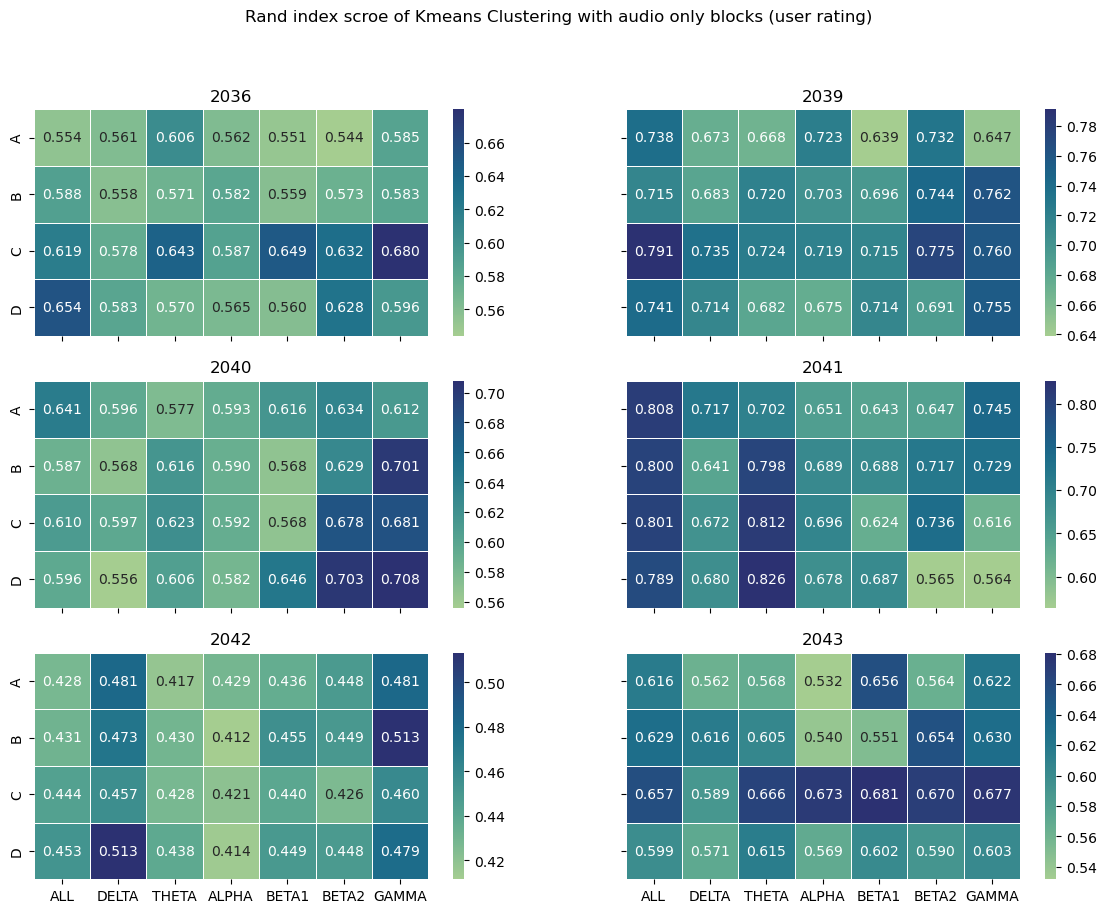

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(14, 10))
fig.suptitle('Rand index scroe of Kmeans Clustering with audio only blocks (user rating)')
for s, ax in zip(subject_to_heatmap.keys(), axes.flatten()):
    ax.set_title(s)
    sns.heatmap(subject_to_heatmap[s], annot=True, fmt=".3f", linewidths=0.5, ax=ax, cmap="crest")
    

identifier = ",".join(str(s) for s in subjects)
filename = f"results/resample_{identifier}_rand_index_kmeans_audio_user.png"
fig.show()
plt.savefig(filename)

### Others

In [ ]:
from dataframe.visualization import pca_2d

# Add the cluster vector to our DataFrame, X
normalized_eeg_features["Cluster"] = clusters
# normalized_eeg_features['Block'] = all_blocks

pca_2d(
    normalized_eeg_features,
    4,
    [
        "rgba(255, 128, 255, 0.8)",
        "rgba(255, 128, 2, 0.8)",
        "rgba(0, 255, 200, 0.8)",
        "rgba(0, 128, 200, 0.8)",
    ],
    "hello",
    False,
    mode="markers",
    textfont=dict(size=10),
)

In [ ]:
for f in ["ALL", "DELTA", "THETA", "ALPHA", "BETA1", "BETA2", "GAMMA"]:
    plotX = get_umap(f, result, all_blocks, subjects)
    feature = f"{f}_UMAP"
    show_result(feature, subjects, plotX, condition)


In [ ]:
# from sklearn.mixture import GaussianMixture
# import matplotlib.pyplot as plt

# gmm = GaussianMixture(n_components=2).fit(normalized_eeg_features)
# clusters = gmm.predict(normalized_eeg_features)


In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn import metrics

# db = DBSCAN(eps=7, min_samples=10).fit(normalized_eeg_features)
# clusters = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
# n_noise_ = list(clusters).count(-1)

# print("Estimated number of clusters: %d" % n_clusters_)
# print("Estimated number of noise points: %d" % n_noise_)
# clusters
